###                        Modelling Using 4 Different Types of Classification Algorithms

In [45]:
#import the required libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, preprocessing
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [2]:
#import data
stroke_data = pd.read_csv('../data/stroke_data_explored.csv')

In [4]:
#Checking the number of rows and columns
stroke_data.shape

(5109, 11)

In [8]:
# Convert categorical data into dummy features
stroke_data = pd.get_dummies(stroke_data)
# Reordering the DataFrameccolumns
reorder = list(stroke_data.columns)
reorder.remove('stroke')
reorder.append('stroke')
stroke_data = stroke_data[reorder]

In [9]:
# Checking for class imbalance
stroke_data['stroke'][stroke_data['stroke']==0].count()

4860

In [10]:
# Imbalance handling using up-resampling 
from sklearn.utils import resample

without_stroke = stroke_data[stroke_data.stroke == 0]
with_stroke = stroke_data[stroke_data.stroke == 1]

with_stroke_upsampled = resample(with_stroke,
                       replace=True,
                       n_samples=4860,
                       random_state=0)

stroke_data_upsampled = pd.concat([without_stroke,with_stroke_upsampled])

stroke_data_upsampled.stroke.value_counts()

1    4860
0    4860
Name: stroke, dtype: int64

In [62]:
#Splitting data into dependent and independent features
#y = stroke_data_upsampled['stroke']
#X = stroke_data_upsampled.drop('stroke', axis=1)
y = stroke_data['stroke']
X = stroke_data.drop('stroke', axis=1)

In [64]:
#Splitting the data into train set and test set 
import sklearn.model_selection #as train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4087, 20) (1022, 20) (4087,) (1022,)


In [65]:
#Using Standard Scaler to scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model1:
### KNearestNeighbor using Grid Search CV for Hyperparameter optimization

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train_scaled,y_train)
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9520429264438744
Best Parameters: {'n_neighbors': 8}


Testing Score :  0.9471624266144814
Confusion Matrix


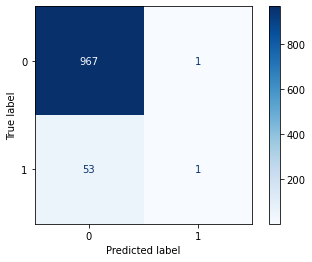

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.50      0.02      0.04        54

    accuracy                           0.95      1022
   macro avg       0.72      0.51      0.50      1022
weighted avg       0.92      0.95      0.92      1022



In [67]:
model1 = KNeighborsClassifier(n_neighbors=8)
model1.fit(X_train_scaled,y_train)
y_pred1 = model1.predict(X_test_scaled)

score1 = model1.score(X_test_scaled, y_test)
print('Testing Score : ',score1)
print('Confusion Matrix')
plot_confusion_matrix(model1,X_test_scaled,y_test,cmap="Blues")
plt.show()
print('Classification Report')
print(classification_report(y_test,y_pred1))


#### Observation1 :
The best parameter obtained by implementing GridSearchCV is n_neighbors = 8.
Training the KNeighborsClassifier model on the data yielded a test score of 94%.

Out of 1020 predicted values for no stroke the: 
The model made 967 correct predictions.
There are 53 incorrect predictions.

Out of 2 predicted values for stroke:
1 was correct prediction and one was wrong prediction.

Overall, the model has 94% accuracy.

### Model2:
### Decision Tree


 The test score for DecisionTree is : 0.9099804305283757


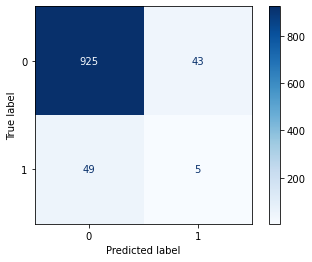

Classification Report For DecisionTree
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       968
           1       0.10      0.09      0.10        54

    accuracy                           0.91      1022
   macro avg       0.53      0.52      0.53      1022
weighted avg       0.91      0.91      0.91      1022



In [77]:
#Implementing Decision Tree

#import required library
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(random_state = 42)
model2.fit(X_train_scaled,y_train)
y_pred2 = model2.predict(X_test_scaled)
score2 = model2.score(X_test_scaled, y_test)
print('\n The test score for DecisionTree is :',score2)
plot_confusion_matrix(model2,X_test_scaled,y_test,cmap="Blues")
plt.show()
print('Classification Report For DecisionTree')
print(classification_report(y_test,y_pred2))

#### Observation 2:

Out of 1020 predicted values for 'no stroke' the: 
The model made 925 correct predictions.
There are 49 incorrect predictions.

Out of 48 predicted values for 'stroke':
5 were correct prediction and 43 were wrong prediction.

Overall, the model has 90% accuracy and the model accuracy is very poor for predicting stroke(negative value)

### Model3:
### RandomForestClassifier  using RandomSearchCV for Hyperparameter optimization

In [78]:
#Implementing RandomSearchCV for Hyperparameter optimization and selection 

#import required library
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier()

#Number of trees
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#Number of features to consider in every split
max_features = ['auto', 'sqrt']
#Max number of levels
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=11)]
max_depth.append(None)
#Max number of samples needed to split at a node
min_samples_split = [2,5,10]
#Min number of samples needed ato split at a node
min_samples_leaf = [1,2,4]
#Method of selecting sample to train each tree
bootstrap = [True, False]

#Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 
               }

#Random Search using 3 fold cross validation and random grid
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#Fit the model
rf_random.fit(X_train_scaled,y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [79]:
print(rf_random.best_score_)
print(rf_random.best_estimator_)

0.9522877359083447
RandomForestClassifier(max_depth=46, min_samples_leaf=4, n_estimators=1800)


Confusion Matrix

 Test score for RandomForestClassifier is :  0.9471624266144814


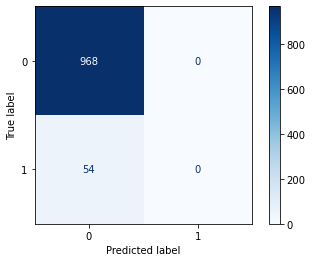

Classification Report For RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.00      0.00      0.00        54

    accuracy                           0.95      1022
   macro avg       0.47      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022



/Users/pranoti/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
#Creating the RandomForestClassifier model using the best parameters from RandomSearchCV
model3 = RandomForestClassifier(max_depth=46, min_samples_leaf=4, n_estimators=1800, random_state=24)#(n_estimators=800, criterion='gini', max_depth = None, max_features='sqrt', min_samples_leaf=1,min_samples_split=2)
model3.fit(X_train_scaled,y_train)

#Model prediction on test set
y_pred3 = model3.predict(X_test_scaled)
print('Confusion Matrix')

score3 = model3.score(X_test_scaled, y_test)
print('\n Test score for RandomForestClassifier is : ', score3)
plot_confusion_matrix(model3,X_test_scaled,y_test,cmap="Blues")
plt.show()
print('Classification Report For RandomForestClassifier:')
print(classification_report(y_test,y_pred3))


####  Observation 3:

Best parameters obtained by implementing RandomSearchCV are max_depth=46, min_samples_leaf=4, n_estimators=1800.

Using these parameters the trained model gave following output:

Out of 1022 predicted values: 
The model made 968 correct predictions for 'no stroke'(True positives).
There are 54 incorrect predictions(False positives).
The model made 0 correct predictions for stroke(True negatives and False negatives)

Overall, the model has 95% accuracy and the models accuracy is very poor for predicting stroke(negative value)

### Model4:
### LogisticRegression


 Testing Score for LogisticRegression is :  0.9481409001956947


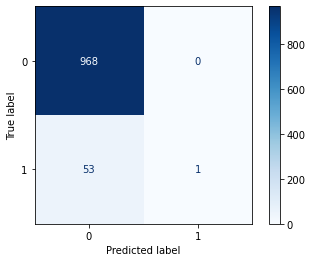

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       1.00      0.02      0.04        54

    accuracy                           0.95      1022
   macro avg       0.97      0.51      0.50      1022
weighted avg       0.95      0.95      0.92      1022



In [84]:
from sklearn.linear_model import LogisticRegression

model4 = LogisticRegression(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4 = model4.predict(X_test_scaled)

score4 = model4.score(X_test_scaled, y_test)
print('\n Testing Score for LogisticRegression is : ',score4)
plot_confusion_matrix(model4,X_test_scaled,y_test,cmap="Blues")
plt.show()
print('Classification Report for LogisticRegression:')
print(classification_report(y_test,y_pred4))

#### Observation 4:

Out of 1021 predicted values: 

The model made 968 correct predictions for 'no stroke'(True positives).
There are 53 incorrect predictions(False positives).
The model made 1 correct prediction for stroke(True negatives)
The model made 0 prediction for False negative

Overall, the model has 95% accuracy and the models accuracy is very poor for predicting stroke(negative value)

### Summary:

The stroke data was analysed and processed for machine learning model implementation to predict stroke based on history of medical conditions and lifestyle features.
Predicition of stroke being a classification problem,four different types of classification machine learning algorithms were implemented and performance of different models were evaluated to find the best model to predict the stroke. 
The models were compared and eveluated using the confusion Matrix and classification report.


### Conclusion:

Out of all the applied models on the stroke data to predict the possiblity of a person getting stroke, KNearestNeighbor with overall prediction accuracy of 95% is the best model. The model is sesitive to positive statistical prediction. The model is likely to make acurate predictions 97% of times for a person who is less likely of getting stroke.